In [1]:
import numpy as np

In [2]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Extra packages
import collections

In [3]:
def plot_distribution(ax, pdfs, title=''): 
    x = np.linspace(0., 10., 200)
    ymax = 0    
    for index, pdf in enumerate(pdfs):
        y = norm.pdf(x, pdf.mean, np.sqrt(pdf.var))

        p = ax.plot(x, y, lw = 2)
        c = p[0].get_markeredgecolor()    
        ax.fill_between(x, y, 0, color=c, alpha=0.2 )    
        ax.autoscale(tight=True)
        ax.vlines(pdf.mean, 0, y.max(), colors = c, linestyles = "--", lw = 2)    

        ymax = max( ymax, y[1:].max()*1.05 )
    ax.set_ylim([0,ymax])

def plot_regret(ax, regret, title=''): 
    ax.plot(regret)

def plot(regret, mab):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    plot_regret(axs[0], regret)
    plot_distribution(axs[1], mab)

In [4]:
class Arm:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var

    def sample(self):
        return np.random.normal(self.mean, np.sqrt(self.var))

    def name(self):
        return 'N(' + str(self.mean) + ',' + str(self.var) + ')'

# Thompson Sampling

In this exercise we will run thompson sampling for 2-armed bandit with gaussian distribution.
For simplicity assume we know variance of distribution of arms and only mean is unknown
for prior assume gaussian distribution.

## 1.
if variance was unknown what prior distribtion would be suitable?

If both mean and variance was unknown, then the following joint distribution would be a conjugate prior:
$$ \sigma \sim Ga(\alpha, \beta) $$
$$ \mu | \sigma \sim \mathcal{N}(\mu_0, n_0\sigma) $$

## 2.
Implement Thompson Sampling algorithm. For comparison also implement ϵ-Greedy and UCB algorithms

In [5]:
class ThompsonSampling:
    def __init__(self, var_list, **kwargs):
        """
        variance of arms are known to policy
        """
        self.n_arms = len(var_list)
        self.var_list = var_list
        # Initialize prior means to zero
        self.prior_means = np.zeros((self.n_arms, ))
        # Initialize prior variances to 1
        self.prior_vars = np.ones((self.n_arms, )) * 1000
        self.num_selects = np.zeros((self.n_arms, ))

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on estimate of prior distribution
        # return index of selected arm
        sampled_means = [
            np.random.normal(*x) for x in zip(self.prior_means, self.prior_vars)
        ]
        return np.argmax(sampled_means)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        self.num_selects[idx] += 1
        # update prior based on reward
        self.prior_means[idx] = (self.prior_vars[idx] / (self.prior_vars[idx] + self.var_list[idx])) * reward \
        + (self.var_list[idx] / (self.prior_vars[idx] + self.var_list[idx])) * self.prior_means[idx]
        self.prior_vars[idx] = 1 / (1 / self.prior_vars[idx] + 1 / self.var_list[idx])
        
        return self.num_selects, self.prior_means
        # ==================================== Your Code (End) ====================================

In [6]:
class UCB:    
    def __init__(self, n_bandits, c_level):
        """
        c_level: coefficient of uncertainty
        """
        self.n_bandits = n_bandits
        self.c_level = c_level
        self.num_selects = np.zeros((n_bandits, ))
        self.estimated_means = np.zeros((n_bandits, ))
    
    def select_arm(self, t):
        """
        t: step time
        """
        # ==================================== Your Code (Begin) ==================================
        # select arm based on UCB
        # return index of selected arm
        
        # If there exists an arm which has not been selected yet, choose it.
        for i in range(self.n_bandits):
            if self.num_selects[i] == 0:
                return i
        
        scores = self.estimated_means + self.c_level * np.sqrt(np.log(t) / self.num_selects)
        return np.argmax(scores)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update based on reward
        self.num_selects[idx] += 1
        self.estimated_means[idx] += (reward - self.estimated_means[idx]) / self.num_selects[idx]
        
        return self.num_selects, self.estimated_means
        # ==================================== Your Code (End) ====================================

In [7]:
class eGreedy:    
    def __init__(self, n_bandits, epsilon):
        """
        epsilon must be given
        """
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.num_selects = np.zeros((n_bandits, ))
        self.estimated_means = np.zeros((n_bandits, ))
    
    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on e-Greedy
        # return index of selected arm
        rand_num = np.random.rand()
        if rand_num < self.epsilon:
            return np.random.choice(range(self.n_bandits))
        return np.argmax(self.estimated_means)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update based on reward
        self.num_selects[idx] += 1
        self.estimated_means[idx] += (reward - self.estimated_means[idx]) / self.num_selects[idx]
        
        return self.num_selects, self.estimated_means
        # ==================================== Your Code (End) ====================================

## 3
run simulation for arms described as cells below and describe the differences of regret with different variance in arms distributions

rum_sim1 must return cumulitive regret formulated as 
$$
R(T)=\sum_{i=1}^2 N_i(T) \Delta_i
$$

where $N_i(T)$ is number of times arm $i$ was selected until step $T$, $\Delta_i=\mu^*-\mu_i$, $\mu^*$ is largest mean in arms distribtions and $\mu_i$ is mean of distribution of arm $i$

to get average regret we rum simulation 50 times.

In [8]:
def run_sim1(policy, mab, step_num=100):
    """
    run simulation of multi-armed bandit
    mab: list of arms
    """
    best_mean = np.max([b.mean for b in mab])
    regret = []
    for k in range(1, step_num+1):          
        # ==================================== Your Code (Begin) ==================================
        # run policy algorithm and return cumulative regret
        idx = policy.select_arm(k)
        reward = mab[idx].sample()
        Ns, mus = policy.update(idx, reward)
        R = (Ns * (best_mean - mus)).sum()
        regret.append(R)
        # ==================================== Your Code (End) ====================================
    return regret

### 3.1
Assume Multi-Armed Bandit variables are as follows.

In [9]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]

#### Thompson Sampling
run and describe the result.

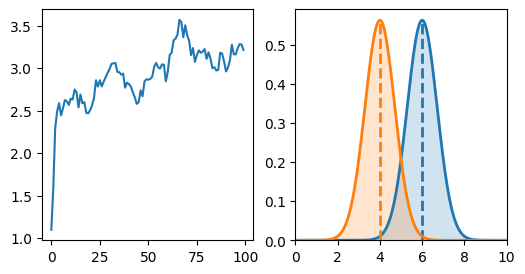

In [10]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

# TODO

#### ϵ-Greedy
run for different values of ϵ and compare results.

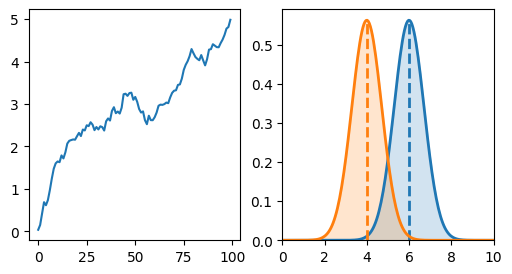

In [11]:
epsilon = 0.05
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

# TODO

#### UCB
run for different values of confidence level and compare results.


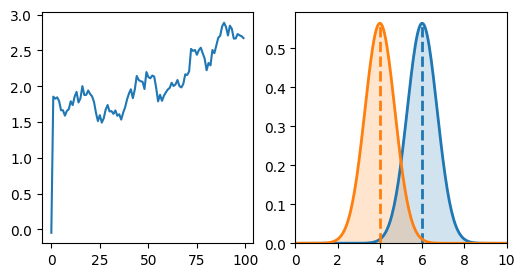

In [12]:
c_level = 1
regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

# TODO

### 3.2
Assume Multi-Armed Bandit variables are as follows.

In [13]:
mab = [Arm(6, 10), Arm(4, 10)]

#### Thompson Sampling
run and compare results.

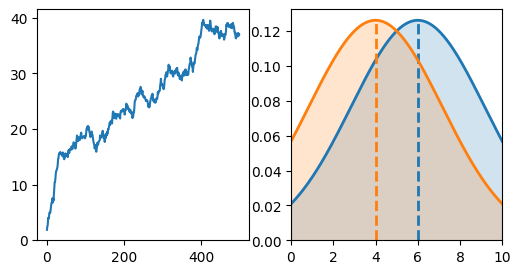

In [14]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

# TODO

#### ϵ-Greedy
run for different values of ϵ and compare results.

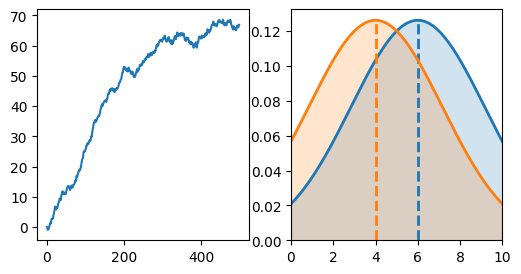

In [15]:
epsilon = 0.05
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

# TODO

#### UCB
run for different values of confidence level and compare results.

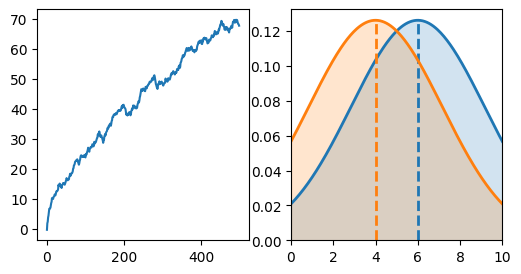

In [16]:
c_level = 5
regret = [run_sim1(UCB(2, c_level=c_level), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

# TODO

## 4
simulation below assumes a non-stationary multi-armed bandit. specifically in this simulation mean value of distribution of first arm changes in step 100. describe the result of thompson sampling.

In [65]:
def run_sim2(ts, mab, step_num=200, change_step=100):
    init_mean = mab[0].mean
    best_mean = np.max([b.mean for b in mab])
    regret = []
    for i in range(1, step_num+1):
        if i == change_step:
            mab[0].mean = 2
            best_mean = np.max([b.mean for b in mab])
            
        # ==================================== Your Code (Begin) ==================================
        # run tompson sampling algorithm and return cumulative regret
        idx = ts.select_arm(i)
        reward = mab[idx].sample()
        Ns, mus = ts.update(idx, reward)
        R = (Ns * (best_mean - mus)).sum()
        regret.append(R)
        # ==================================== Your Code (End) ====================================
    mab[0].mean = init_mean
    return regret

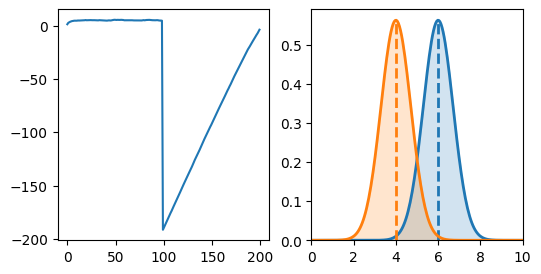

In [66]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

# TODO

### 4.1
change thompson sampling algorithm to improve results in non-stationary MAB.

[Sliding-Window Thompson Sampling for Non-Stationary Settings](https://www.jair.org/index.php/jair/article/download/11407/26587/23707)

In [67]:
class NewThompsonSampling:
    def __init__(self, var_list, buffer_size=30, **kwargs):
        self.n_arms = len(var_list)
        self.var_list = var_list
        self.num_selects = np.zeros((self.n_arms, ))
        self.buffers = [
            collections.deque(maxlen=buffer_size) for i in range(self.n_arms)
        ]
        self.prior_means = np.zeros((self.n_arms, ))
        self.prior_vars = np.ones((self.n_arms, )) * 1000
        self.posterior_means = np.zeros((self.n_arms, ))
        self.posterior_vars = np.ones((self.n_arms, )) * 1000

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on estimate of prior distribution
        # return index of selected arm
        sampled_means = [
            np.random.normal(*x) for x in zip(self.posterior_means, self.posterior_vars)
        ]
        return np.argmax(sampled_means)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update prior based on reward
        self.num_selects[idx] += 1
        self.buffers[idx].append(reward)
        
        for i in range(self.n_arms):
            S = sum(self.buffers[i])
            N = len(self.buffers[i])
            self.posterior_means[i] = (self.prior_vars[i] * S + self.var_list[i] * self.prior_means[i]) \
            / (N * self.prior_vars[i] + self.var_list[i])
            self.posterior_vars[i] = self.prior_vars[i] * self.var_list[i] \
            / (N * self.prior_vars[i] + self.var_list[i])
        
        return self.num_selects, self.posterior_means
        # ==================================== Your Code (End) ====================================

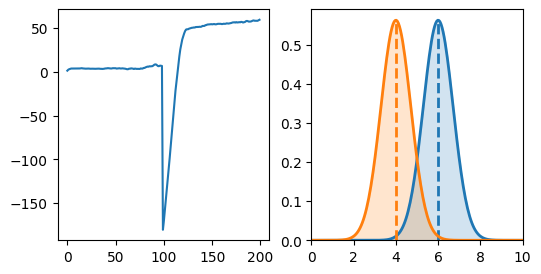

In [68]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(NewThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)